Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0825 - val_loss: 0.0635
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0473 - val_loss: 0.0085
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_lo

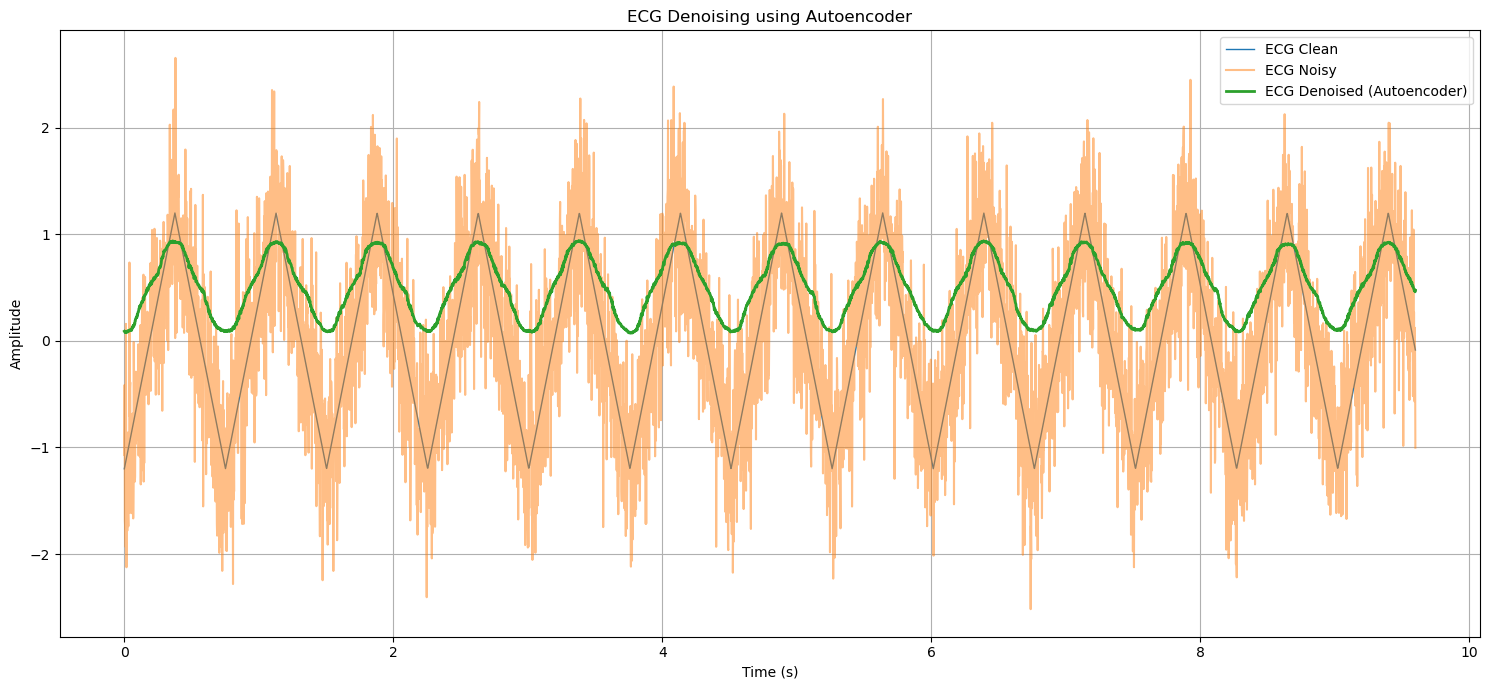

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# --- Step 1: Generate synthetic ECG signal with noise ---
fs = 500  # Sampling frequency in Hz
t = np.linspace(0, 10, fs * 10)  # 10-second time vector

# Synthetic ECG using a sawtooth waveform (QRS-like)
ecg_clean = 1.2 * signal.sawtooth(2 * np.pi * 1.33 * t, 0.5)
noise = 0.5 * np.random.normal(0, 1, len(t))
ecg_noisy = ecg_clean + noise

# --- Step 2: Apply low-pass Butterworth filter ---
def butter_lowpass(cutoff, fs, order=4):
    return signal.butter(order, cutoff / (0.5 * fs), btype='low', analog=False)

def apply_lowpass_filter(data, cutoff=40, fs=500, order=4):
    b, a = butter_lowpass(cutoff, fs, order)
    return filtfilt(b, a, data)

ecg_filtered = apply_lowpass_filter(ecg_noisy)

# --- Step 3: Segment signal into fixed-length windows ---
def create_segments(signal, segment_len):
    segments = []
    for i in range(len(signal) - segment_len):
        segment = signal[i:i + segment_len]
        segments.append(segment)
    return np.array(segments)

segment_len = 200
X_noisy = create_segments(ecg_noisy, segment_len)
X_clean = create_segments(ecg_clean, segment_len)

# Normalize between 0 and 1
X_noisy = (X_noisy - np.min(X_noisy)) / (np.max(X_noisy) - np.min(X_noisy))
X_clean = (X_clean - np.min(X_clean)) / (np.max(X_clean) - np.min(X_clean))

# --- Step 4: Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_noisy, X_clean, test_size=0.2, random_state=42)

# --- Step 5: Define Autoencoder architecture ---
input_layer = Input(shape=(segment_len,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
output_layer = Dense(segment_len, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# --- Step 6: Train the model ---
history = autoencoder.fit(X_train, y_train,
                          epochs=20,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test, y_test),
                          verbose=1)

# --- Step 7: Apply model to noisy data ---
denoised_segments = autoencoder.predict(X_noisy)

# Reconstruct the denoised signal from segments
def reconstruct_signal(segments):
    signal = []
    for seg in segments:
        signal.extend(seg[:1])  # Only use first sample (no overlap)
    return np.array(signal)

ecg_denoised = reconstruct_signal(denoised_segments)

# Trim original signals to match reconstructed length
length = len(ecg_denoised)
t_short = t[:length]
ecg_clean_short = ecg_clean[:length]
ecg_noisy_short = ecg_noisy[:length]

# --- Step 8: Plot results ---
plt.figure(figsize=(15, 7))
plt.plot(t_short, ecg_clean_short, label='ECG Clean', linewidth=1)
plt.plot(t_short, ecg_noisy_short, label='ECG Noisy', alpha=0.5)
plt.plot(t_short, ecg_denoised, label='ECG Denoised (Autoencoder)', linewidth=2)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('ECG Denoising using Autoencoder')
plt.grid(True)
plt.tight_layout()
plt.show()